In [1]:
import os
import numpy as np
import pandas as pd
import arviz as az
import numpyro
import numpyro.infer.initialization as init
import numpyro.distributions as dist
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, SVI, Predictive, init_to_median
from numpyro.infer.reparam import CircularReparam

from asterion.priors import AsyPrior, HeGlitchPrior, CZGlitchPrior, ZerosPrior
from asterion.gp import GP, SquaredExponential
from asterion import Inference, GlitchModel
# from asterion.inference import CircularReparam
from numpyro.distributions import constraints


In [2]:
data_dir = 'data/prior'
track_name = 'm1.0Y0.26FeH0.0MLT2.1ov0.003556dif1'
track_dir = os.path.join(data_dir, track_name)

track = pd.read_csv(os.path.join(track_dir, f'{track_name}.csv'))
track.head()

,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,initial_fov,star_mass,...,E_0_31,E_0_32,E_0_33,E_0_34,E_0_35,E_0_36,E_0_37,E_0_38,E_0_39,E_0_40
0,profile4,152,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,1.216230e-06,0.000002,0.000006,0.000279,0.000014,0.000003,0.000002,0.000001,8.677974e-07,7.314938e-07
1,profile5,153,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,1.070235e-06,0.000002,0.000004,0.000047,0.000027,0.000004,0.000002,0.000001,8.865659e-07,7.333283e-07
2,profile6,154,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,9.770822e-07,0.000002,0.000003,0.000022,0.000059,0.000005,0.000002,0.000001,9.058076e-07,7.371980e-07
3,profile7,155,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,9.140089e-07,0.000001,0.000003,0.000014,0.000159,0.000006,0.000002,0.000001,9.237271e-07,7.414930e-07
4,profile8,156,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,8.694409e-07,0.000001,0.000002,0.000010,0.000672,0.000007,0.000002,0.000001,9.400169e-07,7.457830e-07


In [3]:
model_number = 708
profile = track.loc[track['model_number']==model_number].iloc[0]

In [4]:
n = np.arange(10, 30)
nu_index = [f'nu_0_{i}' for i in n]
# n = n.astype(float)

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

In [5]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_sca = profile['delta_nu']
print('delta_nu ~', round(delta_nu_sca, 2), 'muHz')

nu_max ~ 3246.74 muHz
delta_nu ~ 146.6 muHz


Text(0, 0.5, 'nu mod. 140.74 muHz')

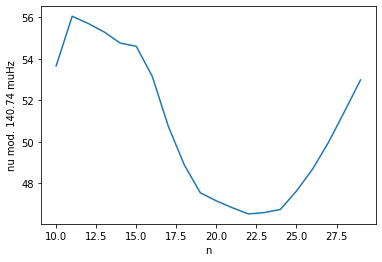

In [6]:
f = 0.96
delta_nu_loc = f*delta_nu_sca
plt.plot(n, nu%delta_nu_loc)
plt.xlabel('n')
plt.ylabel(f'nu mod. {delta_nu_loc:.2f} muHz')

In [7]:
background = AsyPrior(delta_nu=(delta_nu_loc, 0.01*delta_nu_loc))

nu_max = (nu_max_sca, 0.05*nu_max_sca)
he_glitch = HeGlitchPrior(nu_max=nu_max)
cz_glitch = CZGlitchPrior(nu_max=nu_max)

In [8]:
model = GlitchModel(background, he_glitch, cz_glitch)

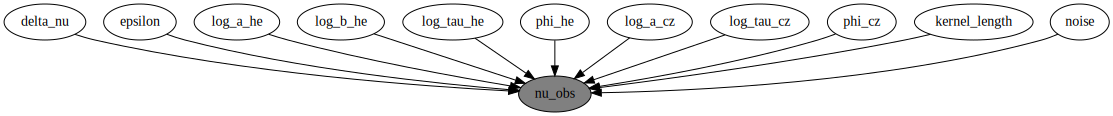

In [9]:
numpyro.render_model(model, model_args=(n,), model_kwargs={'nu': nu})

In [9]:
infer = Inference(model, seed=0)

In [14]:
infer.prior_predictive(model_args=(n,), model_kwargs={'pred': True})

In [15]:
data = infer.get_data()
data

AttributeError: 'InferenceData' object has no attribute 'add_group'

In [ ]:
model.plot_glitch(data, group='prior', quantiles=[.05, .16, .84, .95], observed=False);

In [ ]:
model.plot_glitch(data, kind='CZ', group='prior', quantiles=[.05, .16, .84, .95], observed=False);

In [36]:
infer.find_map(model_args=(n,), model_kwargs={'nu': nu})

100%|██████████| 10000/10000 [00:13<00:00, 739.54it/s, init loss: -5.3679, avg. loss [9501-10000]: -5.3679] 


In [58]:
def func(a=np.array([])):
    a = np.expand_dims(a, -1)
    print(a)

In [46]:
map_estimate = infer.map_predictive(model_args=(n,), model_kwargs={'nu': nu, 'pred': True})

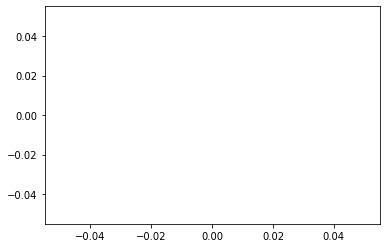

In [33]:
res = nu - map_estimate['nu']
dnu_obs = map_estimate['dnu_he'] + res 
plt.plot(map_estimate['nu_bkg_pred'], map_estimate['dnu_he_pred'])
plt.plot(map_estimate['nu_bkg'], dnu_obs, '.')

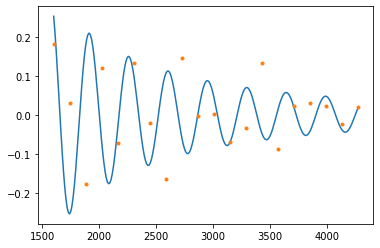

In [13]:
dnu_obs = map_estimate['dnu_cz'] + res 
plt.plot(map_estimate['nu_bkg_pred'], map_estimate['dnu_cz_pred'])
plt.plot(map_estimate['nu_bkg'], dnu_obs, '.')

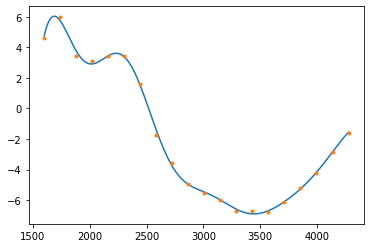

In [17]:
obs_gp = nu - map_estimate['nu_bkg'] - map_estimate['dnu_he'] - map_estimate['dnu_cz']
plt.plot(map_estimate['nu_bkg_pred'], (map_estimate['nu_pred']-map_estimate['nu_bkg_pred']-map_estimate['dnu_he_pred']-map_estimate['dnu_cz_pred']))
plt.plot(map_estimate['nu_bkg'], obs_gp, '.')

In [21]:
# handlers = [he_glitch.reparam, cz_glitch.reparam]

infer.sample(num_chains=5, model_args=(n,), model_kwargs={'nu': nu})

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

AttributeError: 'Inference' object has no attribute 'get_summary'

In [22]:
infer.posterior_predictive(model_args=(n,), model_kwargs={'nu': nu, 'pred': True})

In [23]:
results = infer.get_results()
results.data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

/Users/ajl573/.virtualenvs/asteroglitch/lib/python3.8/site-packages/arviz/plots/traceplot.py:206: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


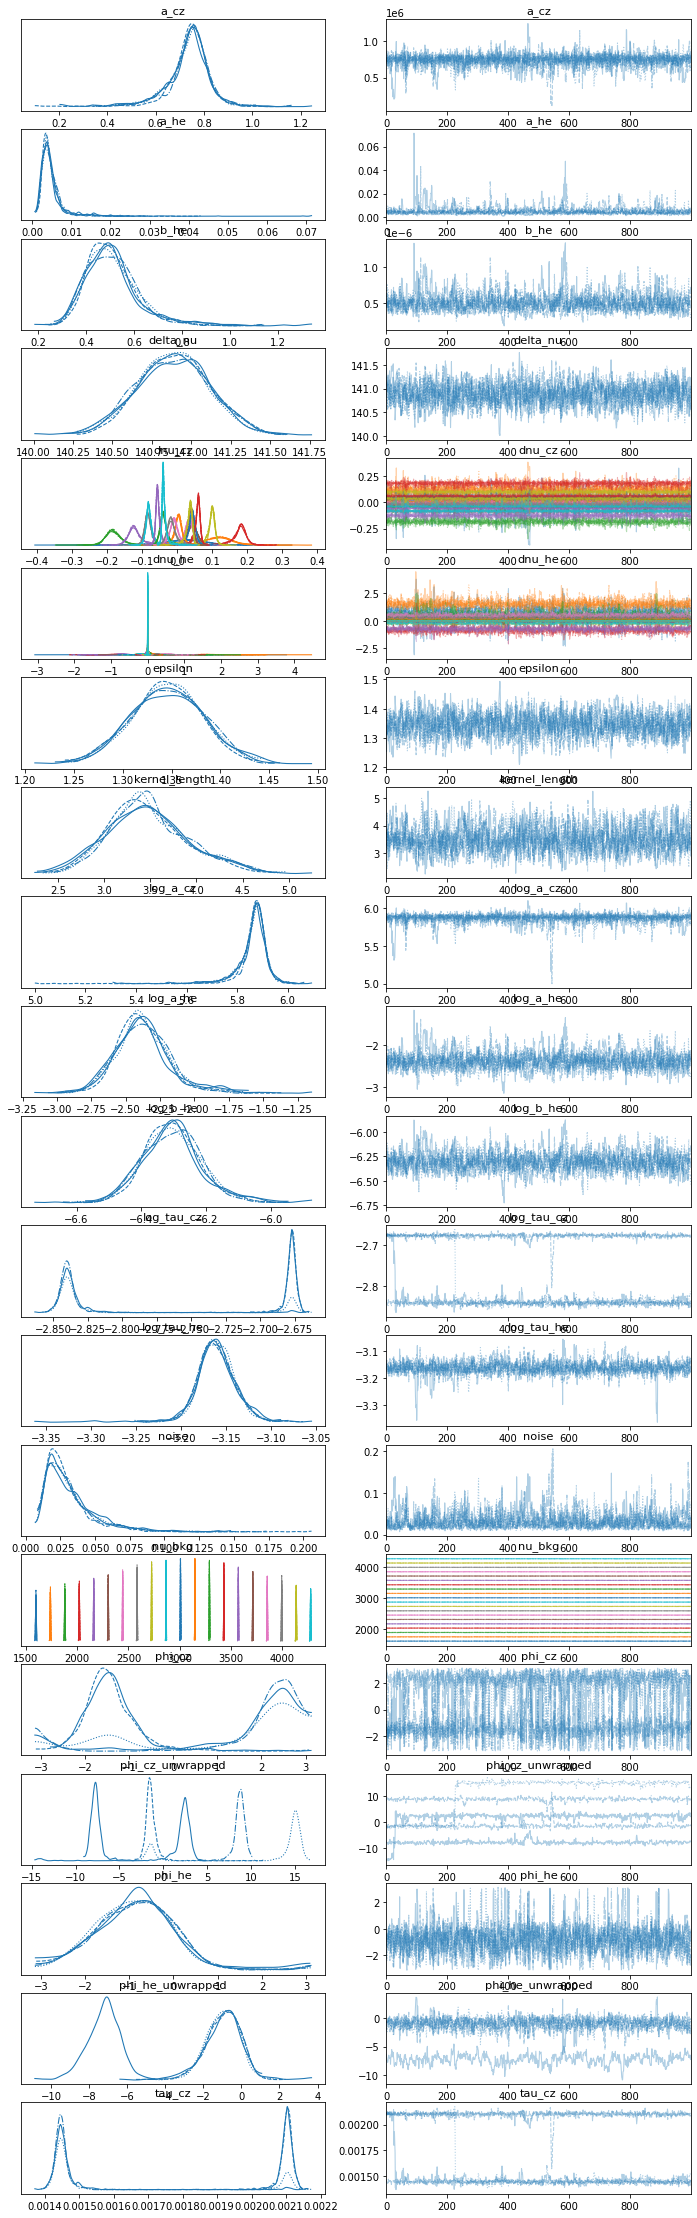

In [24]:
az.plot_trace(results.data);

In [25]:
summary = results.get_summary()
summary

<xarray.Dataset>
Dimensions:           (metric: 12, n: 20)
Coordinates:
  * n                 (n) int64 10 11 12 13 14 15 16 17 ... 23 24 25 26 27 28 29
  * metric            (metric) <U9 'mean' 'sd' 'hdi_3%' ... '16th' '50th' '84th'
Data variables: (12/21)
    a_cz              (metric) float64 7.359e+05 8.833e+04 ... 8.04e+05
    a_he              (metric) float64 0.004785 0.003241 ... 0.004084 0.006292
    b_he              (metric) float64 5.086e-07 1.156e-07 ... 6.004e-07
    delta_nu          (metric) float64 140.9 0.2281 140.4 ... 140.7 140.9 141.1
    dnu_cz            (metric, n) float64 0.01521 0.1186 ... 0.04175 -0.03194
    dnu_he            (metric, n) float64 0.6258 1.543 ... 0.0007366 -0.0001305
    ...                ...
    phi_cz            (metric) float64 -2.858 1.551 1.297 ... -1.77 0.4918 2.585
    phi_cz_unwrapped  (metric) float64 2.534 7.609 -8.351 ... -7.387 2.003 9.808
    phi_he            (metric) float64 -0.9075 0.8879 ... -0.8527 -0.04344
    phi_he_unwrapped  (metric) float64 -2.209 2.682 -7.932 ... -1.183 -0.2001
    tau_cz            (metric) float64 0.001743 0.0003248 ... 0.001475 0.002108
    tau_he            (metric) float64 0.0006908 3.5e-05 ... 0.0006889 0.0007219

In [26]:
results.get_dims()

[(), ('n',)]

In [28]:
results.get_table((), fmt='astropy')

metric,a_cz,a_he,b_he,delta_nu,epsilon,kernel_length,log_a_cz,log_a_he,log_b_he,log_tau_cz,log_tau_he,noise,phi_cz,phi_cz_unwrapped,phi_he,phi_he_unwrapped,tau_cz,tau_he
,uHz3,,Ms2,uHz,,,,,,,,,rad,,rad,,Ms,Ms
str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
mean,735900.0,0.0048,5.09e-07,140.886,1.346,3.49,5.863,-2.375,-6.304,-2.77,-3.1612,0.0316,-2.9,2.5,-0.91,-2.2,0.0017,0.000691
sd,88300.0,0.0032,1.16e-07,0.228,0.037,0.44,0.062,0.203,0.092,0.08,0.0223,0.019,1.6,7.6,0.89,2.7,0.0003,3.5e-05
16th,668300.0,0.0028,4.06e-07,140.658,1.308,3.07,5.825,-2.56,-6.391,-2.84,-3.1791,0.0164,-1.8,-7.4,-1.76,-6.5,0.0014,0.000662
50th,746900.0,0.0041,4.94e-07,140.889,1.346,3.45,5.873,-2.389,-6.307,-2.83,-3.1618,0.0263,0.5,2.0,-0.85,-1.2,0.0015,0.000689
84th,804000.0,0.0063,6e-07,141.108,1.383,3.93,5.905,-2.201,-6.222,-2.68,-3.1415,0.0461,2.6,9.8,-0.04,-0.2,0.0021,0.000722


In [29]:
results.save('.')

In [82]:
save(results, '.')

In [85]:
res = load('.')

In [34]:
example_results = results.get_table(('n', ), group='posterior_predictive', fmt='astropy')

In [36]:
from astropy.io import ascii

In [41]:
ascii.write(example_results, format='ecsv')

# %ECSV 0.9
# ---
# datatype:
# - {name: metric, datatype: string}
# - {name: n, datatype: int64}
# - {name: dnu_cz, unit: uHz, datatype: float64}
# - {name: dnu_he, unit: uHz, datatype: float64}
# - {name: nu, unit: uHz, datatype: float64}
# - {name: nu_bkg, unit: uHz, datatype: float64}
# schema: astropy-2.0
metric n dnu_cz dnu_he nu nu_bkg
mean 10 0.0101 0.6905 1601.7869 1598.21
mean 11 0.1163 1.5272 1744.9153 1739.11
mean 12 -0.1766 0.3711 1885.3094 1880.01
mean 13 0.172 -0.8578 2025.6292 2020.91
mean 14 -0.1163 -0.7156 2165.8456 2161.81
mean 15 0.0396 0.1601 2306.408 2302.71
mean 16 0.0321 0.5164 2445.7067 2443.61
mean 17 -0.0796 0.1721 2584.0456 2584.51
mean 18 0.0944 -0.2004 2722.9077 2725.41
mean 19 -0.0774 -0.1911 2862.3019 2866.31
mean 20 0.041 0.0103 3002.6559 3007.21
mean 21 0.0015 0.1 3143.057 3148.11
mean 22 -0.0362 0.0422 3283.5044 3289.01
mean 23 0.054 -0.027 3424.2752 3429.91
mean 24 -0.0523 -0.0315 3565.2319 3570.81
mean 25 0.0353 -0.0024 3706.8097 3711.71
mean 26 -0.

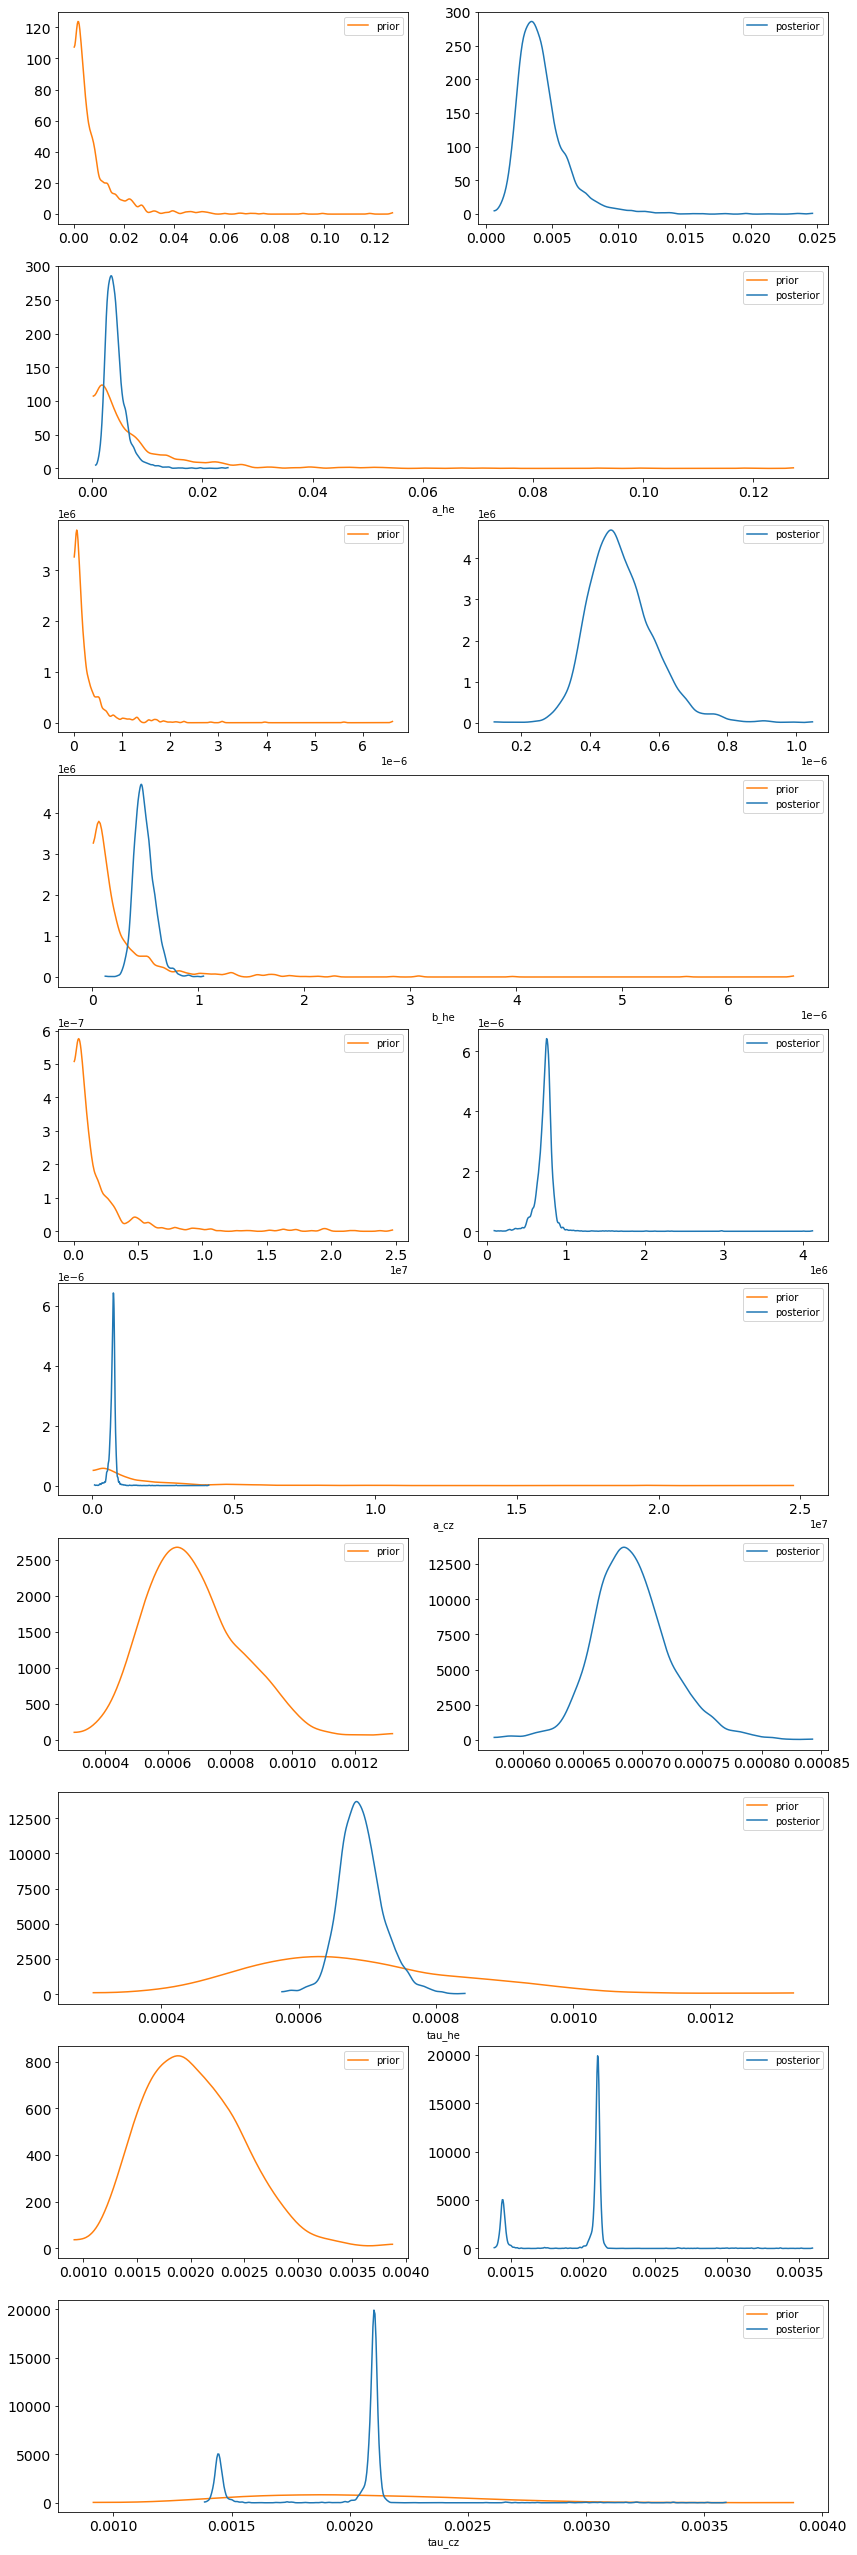

In [91]:
az.plot_dist_comparison(data, var_names=['a_he', 'b_he', 'a_cz', 'tau_he', 'tau_cz']);

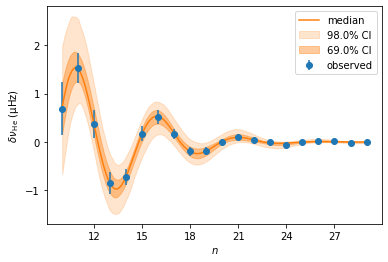

In [92]:
model.plot_glitch(data, quantiles=[.01, .16, .85, .99]);

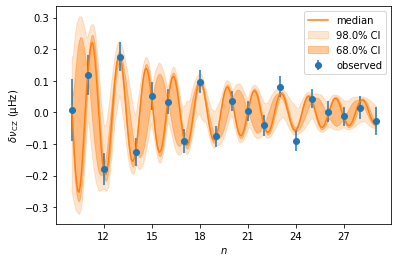

In [93]:
model.plot_glitch(data, kind='CZ', quantiles=[.01, .16, .84, .99]);

Text(0, 0.5, 'nu (muHz)')

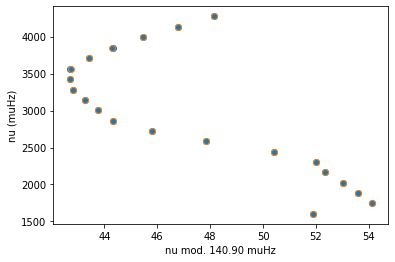

In [94]:
dim = ('chain', 'draw')

delta_nu = data.posterior['delta_nu'].mean(dim=dim)
nu_mean = data.posterior_predictive['nu'].mean(dim=dim)
nu_std = data.posterior_predictive['nu'].std(dim=dim)

nu_obs = data.observed_data['nu_obs']

plt.plot(nu_obs%delta_nu, nu_obs, marker='o', linestyle='none');
plt.errorbar(nu_mean%delta_nu, nu_mean, xerr=nu_std, marker='o', linestyle='none', markerfacecolor='none')

plt.xlabel(f'nu mod. {delta_nu.values:.2f} muHz')
plt.ylabel('nu (muHz)')